In [8]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

start_time='2023-01-01 00:00:00'
stop_time='2024-01-01 00:00:00'
tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db')

start 2023.06.27-234745.db
end 2023.06.27-234745.db


In [2]:
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
tracker.flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta


In [6]:
tracker_initial.flights

,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,track,speed,vertrate,readtime,date,filename,x,y,z,r2,readtime_utc


In [66]:
tracker.flights_distinct = tracker.flights_distinct[tracker.flights_distinct.flightnumber.str.contains('JAL', na=False)].reset_index()
tracker.flights = tracker.flights[tracker.flights.flightnumber.str.contains('JAL', na=False)].reset_index()
flights_distinct

,level_0,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber
20,2361,5551,JAL41,2023-05-11,2023.05.11-051433.db,2023-05-11 01:45:46.500000,2023-05-11 01:53:08.600000,13.0,10.2,79.0,2023-05-11_JAL41
21,3598,3558,JAL407,2023-07-01,2023.07.01-234808.db,2023-07-01 11:23:10.300000,2023-07-01 11:31:07.600000,12.6,10.2,79.0,2023-07-01_JAL407
22,5369,3215,JAL45,2023-10-09,2023.10.09-181048.db,2023-10-09 10:31:18.600000,2023-10-09 10:38:40.700000,11.4,8.9,79.0,2023-10-09_JAL45
23,5370,3216,JAL43,2023-10-09,2023.10.09-181048.db,2023-10-09 11:26:09.600000,2023-10-09 11:33:31.700000,11.4,8.9,79.0,2023-10-09_JAL43
24,5378,2423,JAL41,2023-10-10,2023.10.10-181053.db,2023-10-10 01:40:53.900000,2023-10-10 01:47:55.900000,13.1,10.8,79.0,2023-10-10_JAL41
25,5390,2435,JAL45,2023-10-10,2023.10.10-181053.db,2023-10-10 09:51:27.000000,2023-10-10 09:58:34.000000,11.4,8.9,79.0,2023-10-10_JAL45
26,5391,2436,JAL407,2023-10-10,2023.10.10-181053.db,2023-10-10 10:48:23.600000,2023-10-10 10:55:25.600000,12.0,9.5,79.0,2023-10-10_JAL407
27,5392,2437,JAL43,2023-10-10,2023.10.10-181053.db,2023-10-10 10:56:25.900000,2023-10-10 11:03:33.000000,11.3,8.9,79.0,2023-10-10_JAL43
28,5439,1048,JAL41,2023-10-13,2023.10.13-181108.db,2023-10-13 01:32:31.500000,2023-10-13 01:39:33.600000,12.0,9.6,79.0,2023-10-13_JAL41


In [74]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from pyvirtualdisplay import Display
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import sys

# browser options: do not start window
#options = Options()
#options.add_argument("--headless")

def get_flight_history(flight):
    def get_data(url):
        #browser = webdriver.Firefox(options=options)
        #browser = webdriver.Firefox()
        browser = webdriver.Chrome()
        browser.get(url)
        text = browser.page_source
        browser.quit()
        return text

    # Construct URL using input parameters
    url = f"https://www.flightaware.com/live/flight/{flight}/history"

    # Get HTML data from URL
    html_data = get_data(url)

    # Parse HTML using BeautifulSoup
    soup = BeautifulSoup(html_data, 'html.parser')

    dataframes = []
    # loop through all tables
    for i, table in enumerate(soup.find_all("table")):
        table_contents = []
        # loop through rows
        for row in table.find_all("tr"):
            row_content = {}
            for col in row.find_all("td"):
                # get columns and column contents
                label = col.find("b", class_="tablesaw-cell-label")
                content = col.find("span", class_="tablesaw-cell-content")
                try:
                    row_content[label.get_text()] = content.get_text()
                except:
                    continue
            # skip empty rows
            if len(row_content.keys())==0:
                continue
            table_contents.append(row_content)
        # skip empty tables
        if len(table_contents)==0:
            continue
        dataframe = pd.DataFrame(table_contents)
        dataframe.drop_duplicates(keep="last", inplace=True, ignore_index=True)
        dataframes.append(dataframe)

    return dataframes 

if __name__ == "__main__":
    flight = sys.argv[1]
    dataframes = get_flight_history(flight)
    print(dataframes[0])

get_flight_history("JAL43 ".strip())

IndexError: list index out of range

In [3]:

flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


In [4]:
dates_to_exclude_from_analysis_due_to_missing_detector_data = []

temp_df = pd.DataFrame()
length = len(flights_distinct)
for i in range(length):
    clear_output(wait=True)
    f = tracker.get_flight_by_index(i, filetype = 'headers.root')
    if len(f.header_df) > 0:
        temp_df = pd.concat([temp_df, f.header_df], ignore_index=True, sort=False)
    else: 
        print(f'No detector data for {f.date}')
        dates_to_exclude_from_analysis_due_to_missing_detector_data.append(f.date)
    
    print(f'end: {i + 1}/{length}')
    #print(f.header_df)
    
flights_distinct = flights_distinct[~flights_distinct['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()
flights = flights[~flights['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()
temp_df = temp_df[(temp_df.lt_triggers == 1)]

print('ready to join tables')


No detector data for 2023-12-31
end: 6895/6895
ready to join tables


In [7]:
query = '''
SELECT 
    date || '_' || flightnumber as fk_date_flightnumber
    ,flightnumber
    ,count(trigger_time) as triggers_per_second
    ,trigger_time_sec
    ,date
FROM flights_distinct
LEFT JOIN ( SELECT
                *
                ,strftime('%Y-%m-%d %H:%M:%S', datetime(trigger_time_sec, 'unixepoch')) as trigger_time_formatted
            FROM
            (
                SELECT
                    *
                    ,round(trigger_time, 0) as trigger_time_sec
                FROM temp_df
            )t0
)t1
ON trigger_time_formatted > flights_distinct.mintime
AND trigger_time_formatted < flights_distinct.maxtime
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
GROUP BY flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,fk_date_flightnumber,flightnumber,triggers_per_second,trigger_time_sec,date
0,2023-07-04_AAL135,AAL135,2,1.688501e+09,2023-07-04
1,2023-07-04_AAL135,AAL135,3,1.688501e+09,2023-07-04
2,2023-07-04_AAL135,AAL135,3,1.688501e+09,2023-07-04
3,2023-07-04_AAL135,AAL135,2,1.688501e+09,2023-07-04
4,2023-07-04_AAL135,AAL135,1,1.688501e+09,2023-07-04
...,...,...,...,...,...
677977,2023-07-23_VJT993,VJT993,1,1.690114e+09,2023-07-23
677978,2023-07-23_VJT993,VJT993,1,1.690114e+09,2023-07-23
677979,2023-07-23_VJT993,VJT993,3,1.690114e+09,2023-07-23
677980,2023-07-23_VJT993,VJT993,5,1.690114e+09,2023-07-23


In [9]:
con = sqlite3.connect('./distinct_table_with_header_scores/all_2023')

# Write the DataFrame to the SQLite database
result.to_sql('lt_triggers_header_joined_on_flights_distinct_2023', con, if_exists = 'replace')

# Close the database connection
con.close()

In [11]:
con = sqlite3.connect('./distinct_table_with_header_scores/all_2023')

# Write the DataFrame to the SQLite database
test = pd.read_sql_query('select name from sqlite_master where type = "table"', con)

# Close the database connection
con.close()

In [15]:
flights = tracker_initial.flights
flights

,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,track,speed,vertrate,readtime,date,filename,x,y,z,r2,readtime_utc


In [6]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')
    temp_table['d'] = FlightTracker.part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)
result_df


""


N/A


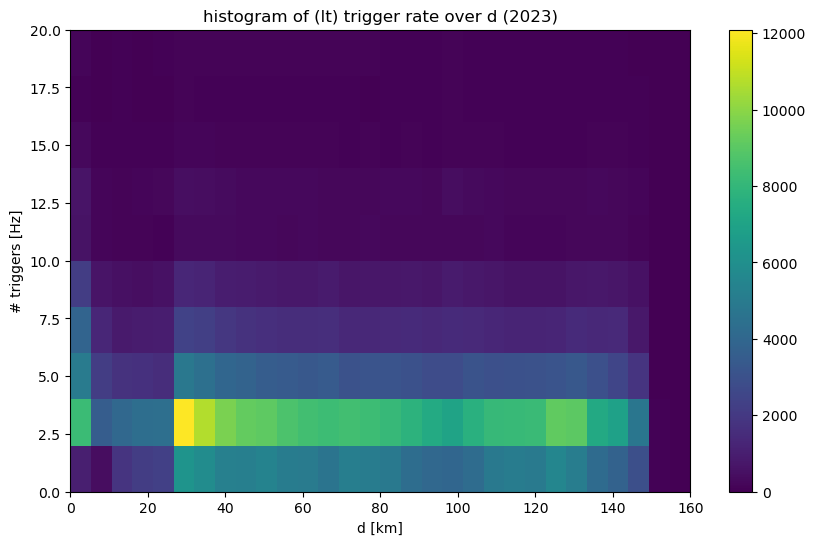

In [53]:
from matplotlib.colors import LogNorm
result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
max_flightnumber = result_df.at[max_index, 'flightnumber']
print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0,20]], bins = [30, 10])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

In [51]:
yedges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [8]:
flights = sqldf('Select * FROM flights order by flightnumber, date, readtime_utc asc')
flights = sqldf('Select *, (JULIANDAY(readtime_utc) - JULIANDAY(LAG(readtime_utc, 1) OVER (Partition by flightnumber, date order by readtime_utc asc))) * 86400 as duration_next_value FROM flights')
flights

,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,track,...,readtime,date,filename,x,y,z,r2,readtime_utc,fk_date_flightnumber,duration_next_value


In [34]:
flights.duration_next_value.min()

4.999972879886627

In [58]:
sqldf('Select duration_next_value, * from flights where duration_next_value < 10000 and flightnumber != "N/A" and flightnumber not like "%SKI%" order by duration_next_value desc').head(10)

,duration_next_value,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,...,readtime,date,filename,x,y,z,r2,readtime_utc,fk_date_flightnumber,duration_next_value
0,5607.299982,409457,None,72.603289,-38.399792,10300.0,0.2,-6.3,RCH108,ae0610,...,2023-07-13 19:52:36.700000,2023-07-13,2023.07.13-234909.db,2.035375,5.575809,3.136673,45.071113,2023-07-13 18:52:36.700000+00:00,2023-07-13_RCH108,5607.299982
1,170.799999,2382484,None,71.154025,-39.061432,34000.0,0.3,-34.2,UAE3U,89644f,...,2023-06-29 16:21:29.700000,2023-06-29,2023.06.29-234758.db,-123.607703,-68.941405,8.795757,20109.146974,2023-06-29 15:21:29.700000+00:00,2023-06-29_UAE3U,170.799999
2,155.699980,3571439,None,71.173903,-38.937378,34000.0,0.5,-34.3,UAE3U,89644e,...,2023-06-30 15:49:50.500000,2023-06-30,2023.06.30-234803.db,-122.097986,-55.122836,8.959331,18026.714870,2023-06-30 14:49:50.500000+00:00,2023-06-30_UAE3U,155.699980
3,135.700008,2361984,None,71.141968,-39.136963,34000.0,0.3,-32.8,PIA789,7608f9,...,2023-06-29 10:21:39.800000,2023-06-29,2023.06.29-234758.db,-124.519691,-77.354986,8.681443,21564.314765,2023-06-29 09:21:39.800000+00:00,2023-06-29_PIA789,135.700008
4,125.600003,4776338,None,71.148651,-39.095282,34000.0,0.5,-32.0,UAE55U,896174,...,2023-08-02 09:13:40.800000,2023-08-02,2023.08.02-235050.db,-124.014170,-72.711988,8.745961,20743.039526,2023-08-02 08:13:40.800000+00:00,2023-08-02_UAE55U,125.600003
5,115.599976,1104245,None,71.210358,-38.853728,36000.0,0.3,-33.8,KLM677,485345,...,2023-04-24 15:33:45.100000,2023-04-24,2023.04.25-051312.db,-119.083986,-45.779445,9.699885,16370.841009,2023-04-24 14:33:45.100000+00:00,2023-04-24_KLM677,115.599976
6,110.600004,3206735,None,71.000793,-38.601765,34000.0,0.5,-32.6,AIC187,8004e0,...,2023-09-30 09:10:57.400000,2023-09-30,2023.09.30-181002.db,-137.770330,-18.055032,8.853837,19385.038415,2023-09-30 08:10:57.400000+00:00,2023-09-30_AIC187,110.600004
7,95.400006,1081353,None,71.299942,-38.130365,35000.0,0.0,-32.7,PIA798,7608fa,...,2023-06-10 06:28:27.100000,2023-06-10,2023.06.11-051709.db,-112.409448,34.758590,9.585439,13935.924161,2023-06-10 05:28:27.100000+00:00,2023-06-10_PIA798,95.400006
8,90.500012,1313606,None,71.189405,-38.839417,34000.0,0.5,-32.8,PIA797,7608f9,...,2023-07-24 10:29:37.800000,2023-07-24,2023.07.24-235004.db,-120.918098,-44.211282,9.066827,16658.031197,2023-07-24 09:29:37.800000+00:00,2023-07-24_PIA797,90.500012
9,80.399966,4198506,None,71.374512,-37.636847,33000.0,0.9,-33.0,AIC126D,800463,...,2023-07-06 12:06:45.600000,2023-07-06,2023.07.06-234833.db,-106.560697,89.700405,8.538986,19474.259051,2023-07-06 11:06:45.600000+00:00,2023-07-06_AIC126D,80.399966


191887    2023-06-29 15:17:28.600000+00:00
191888    2023-06-29 15:17:33.600000+00:00
191889    2023-06-29 15:17:38.600000+00:00
191890    2023-06-29 15:17:43.700000+00:00
191891    2023-06-29 15:17:48.700000+00:00
191892    2023-06-29 15:17:53.700000+00:00
191893    2023-06-29 15:17:58.700000+00:00
191894    2023-06-29 15:18:03.700000+00:00
191895    2023-06-29 15:18:08.800000+00:00
191896    2023-06-29 15:18:13.800000+00:00
191897    2023-06-29 15:18:18.800000+00:00
191898    2023-06-29 15:18:23.800000+00:00
191899    2023-06-29 15:18:28.900000+00:00
191900    2023-06-29 15:18:33.900000+00:00
191901    2023-06-29 15:18:38.900000+00:00
191902    2023-06-29 15:21:29.700000+00:00
191903    2023-06-29 15:21:34.800000+00:00
191904    2023-06-29 15:21:39.800000+00:00
191905    2023-06-29 15:21:44.800000+00:00
Name: readtime_utc, dtype: object


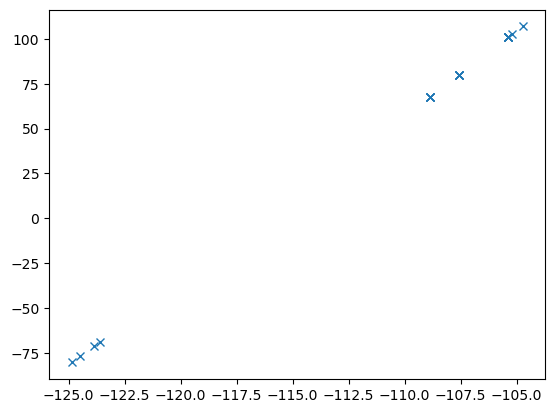

In [66]:
plt.plot(flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].x, flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].y, 'x')
print(flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].readtime_utc)

In [50]:
flights

,level_0,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,...,date,filename,x,y,z,r2,readtime_utc,fk_date_flightnumber,"LAG(readtime_utc, 1) OVER (Partition by flightnumber, date order by readtime_utc asc)","LAG(readtime_utc, 1) OVER (Partition by flightnumber, date order by readtime_utc asc)"
0,216369,2849760,None,72.939423,-39.742073,39000.0,0.2,-15.9,JAL407,86eb14,...,2023-07-01,2023.07.01-234808.db,30.864820,-143.758573,10.190989,21723.020708,2023-07-01 11:23:10.300000+00:00,2023-07-01_JAL407,None,None
1,216370,2849764,None,72.932236,-39.711537,39000.0,0.1,-16.3,JAL407,86eb14,...,2023-07-01,2023.07.01-234808.db,30.261003,-140.360330,10.269647,20722.216156,2023-07-01 11:23:15.300000+00:00,2023-07-01_JAL407,2023-07-01 11:23:10.300000+00:00,2023-07-01 11:23:10.300000+00:00
2,216371,2849768,None,72.925552,-39.683263,39000.0,0.0,-17.6,JAL407,86eb14,...,2023-07-01,2023.07.01-234808.db,29.698895,-137.213829,10.340824,19816.591796,2023-07-01 11:23:20.300000+00:00,2023-07-01_JAL407,2023-07-01 11:23:15.300000+00:00,2023-07-01 11:23:15.300000+00:00
3,216372,2849772,None,72.919053,-39.655666,38975.0,0.2,-18.5,JAL407,86eb14,...,2023-07-01,2023.07.01-234808.db,29.151899,-134.142537,10.401123,18952.236687,2023-07-01 11:23:25.400000+00:00,2023-07-01_JAL407,2023-07-01 11:23:20.300000+00:00,2023-07-01 11:23:20.300000+00:00
4,216373,2849776,None,72.912231,-39.626878,39000.0,0.1,-20.2,JAL407,86eb14,...,2023-07-01,2023.07.01-234808.db,28.577227,-130.939034,10.477980,18071.476731,2023-07-01 11:23:30.400000+00:00,2023-07-01_JAL407,2023-07-01 11:23:25.400000+00:00,2023-07-01 11:23:25.400000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,323794,1948436,None,72.317039,-37.257870,35000.0,0.3,-26.3,JAL45,867f68,...,2023-10-10,2023.10.10-181053.db,-23.366204,132.498009,9.247241,18187.213255,2023-10-10 09:58:13.900000+00:00,2023-10-10_JAL45,2023-10-10 09:58:08.900000+00:00,2023-10-10 09:58:08.900000+00:00
786,323795,1948437,None,72.308520,-37.225880,35000.0,0.0,-25.8,JAL45,867f68,...,2023-10-10,2023.10.10-181053.db,-24.133378,136.051284,9.169476,19176.451070,2023-10-10 09:58:19+00:00,2023-10-10_JAL45,2023-10-10 09:58:13.900000+00:00,2023-10-10 09:58:13.900000+00:00
787,323796,1948438,None,72.300476,-37.195740,35000.0,0.0,-26.2,JAL45,867f68,...,2023-10-10,2023.10.10-181053.db,-24.858334,139.398944,9.094304,20132.708795,2023-10-10 09:58:24+00:00,2023-10-10_JAL45,2023-10-10 09:58:19+00:00,2023-10-10 09:58:19+00:00
788,323797,1948439,None,72.292925,-37.167394,35000.0,0.2,-27.9,JAL45,867f68,...,2023-10-10,2023.10.10-181053.db,-25.539387,142.547239,9.021929,21053.370909,2023-10-10 09:58:29+00:00,2023-10-10_JAL45,2023-10-10 09:58:24+00:00,2023-10-10 09:58:24+00:00


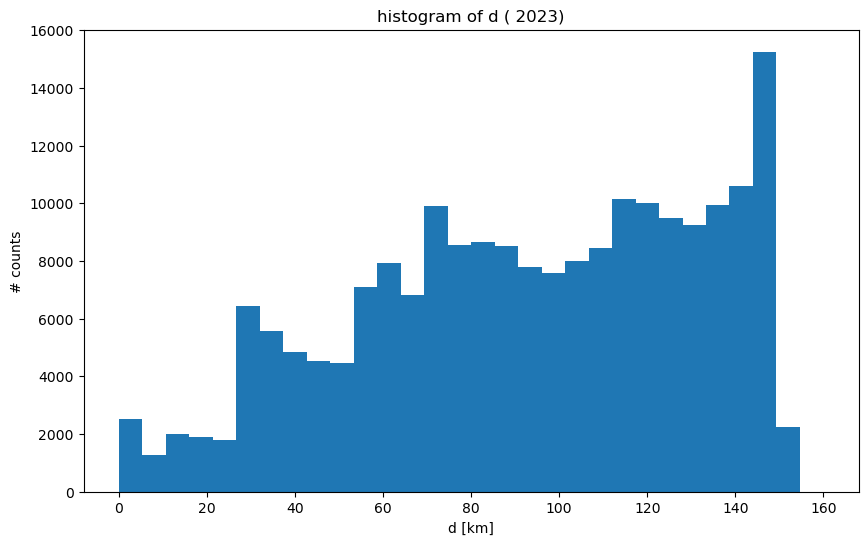

In [54]:
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_8917/3617817080.py:2: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


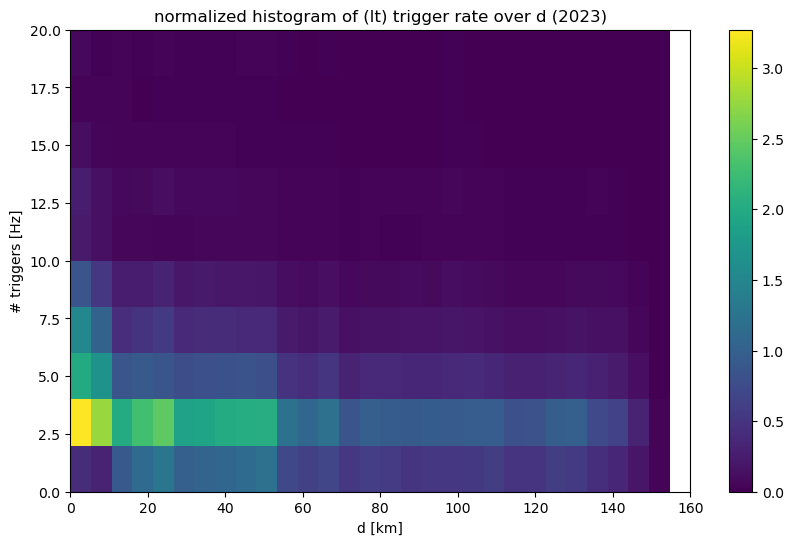

In [55]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

AttributeError: 'DataFrame' object has no attribute 'lt_triggers'

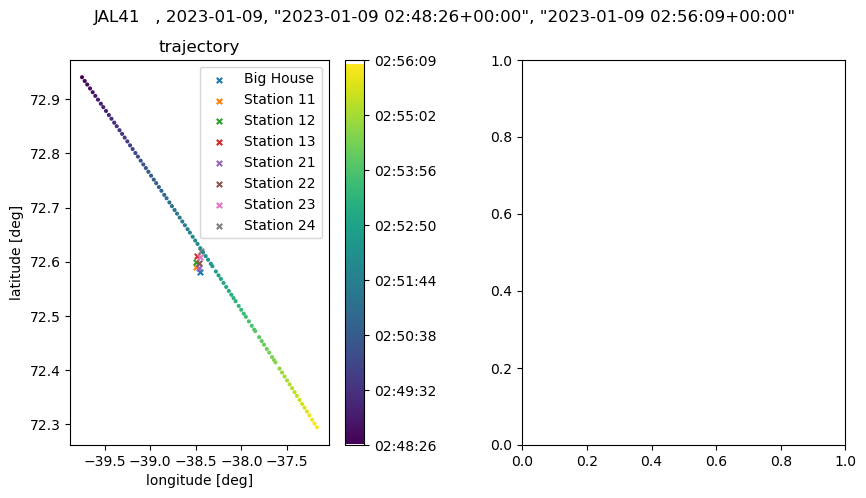

In [37]:
flight0 = tracker.get_flight_by_index(0, filetype = 'headers.root')
flight0.plot_flight(figsize = (10, 5))

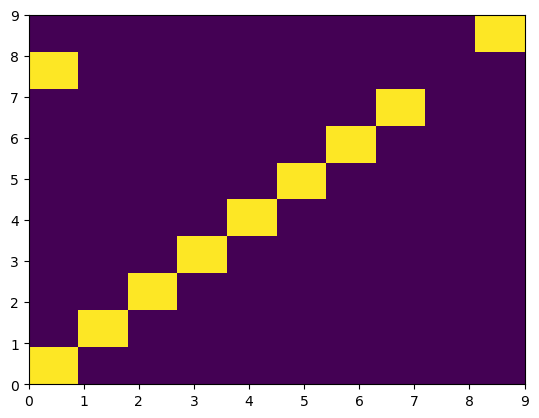

In [104]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 0, 9]
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

h, xedges, yedges, image = plt.hist2d(x, y)

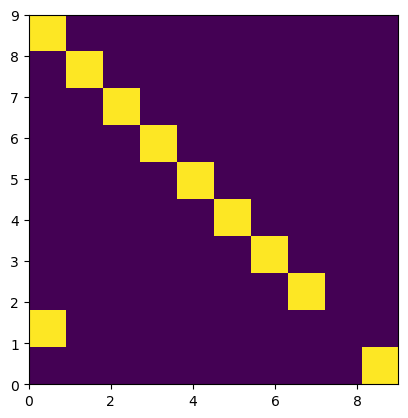

In [108]:
plt.imshow(h.T, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])

/tmp/ipykernel_5639/3462587715.py:1: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(h.T/a[0])
/tmp/ipykernel_5639/3462587715.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


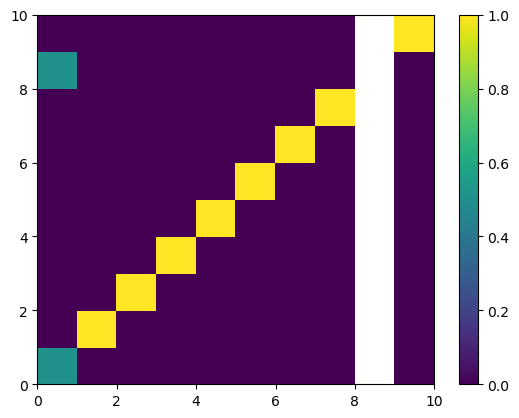

In [112]:
plt.pcolor(h.T/a[0])
plt.colorbar()

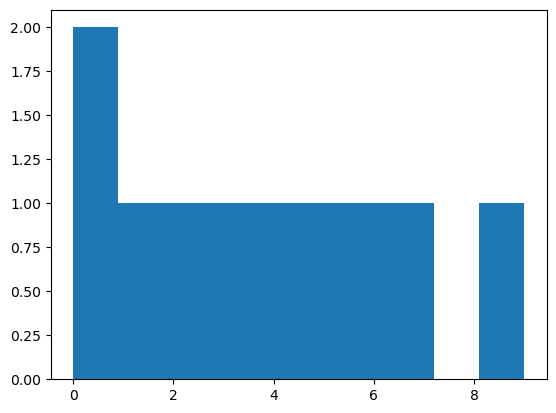

In [88]:
a = plt.hist(x)

In [89]:
a[0]

array([2., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [94]:
h

array([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [91]:
h/a[0]

/tmp/ipykernel_5639/555751462.py:1: RuntimeWarning: divide by zero encountered in divide
  h/a[0]
/tmp/ipykernel_5639/555751462.py:1: RuntimeWarning: invalid value encountered in divide
  h/a[0]


array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , inf, 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 1. ]])

/tmp/ipykernel_5639/1383573379.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(h.T/a[0], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


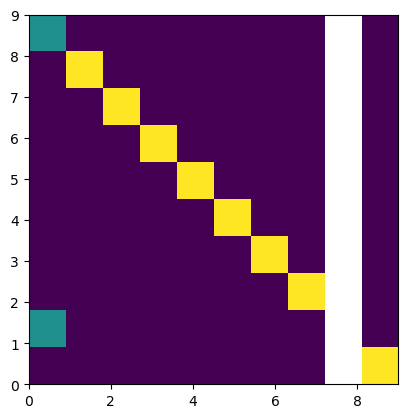

In [103]:
plt.imshow(h.T/a[0], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])